### Домашнее задание к уроку 3. Связь бизнес-показателей и DS-метрик

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix

df = pd.read_csv('train_case2.csv', ';')
df.head()

C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Разделим наши данные на тренировочную и тестовую выборки

In [16]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], random_state=0)
X_train.shape

C:\Users\irina\AppData\Local\Temp/ipykernel_11996/45300079.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], random_state=0)


(52500, 12)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [17]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [18]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [34]:
# В классификаторе меняем параметры моделей для проведения тестов:
classifier = Pipeline([
    ('features', feats),
    # ('classifier', LogisticRegression(C = 0.1, random_state = 42)),
    # ('classifier', GradientBoostingRegressor(n_estimators=100, max_depth=10, criterion='mse', learning_rate=0.03, random_state = 42)),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini', random_state = 42)),
])

In [35]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8012814315210153+-0.006725085121681367


In [36]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)

y_score = classifier.predict_proba(X_test)[:, 1] # Для лог.регрессии и леса
# y_score = classifier.predict(X_test) # Для бустинга

Посчитаем метрики:

In [37]:
b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
rocauc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]) # Для лог.регрессии и леса
logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1]) # Для лог.регрессии и леса
# rocauc = roc_auc_score(y_true=y_test, y_score=classifier.predict(X_test)) # Для бустинга
# logloss = log_loss(y_true=y_test, y_pred=classifier.predict(X_test)) # Для бустинга
ix = np.argmax(fscore)

Запишем метрики в DataFrame:

In [38]:
df = pd.DataFrame({'precision': [round(precision[ix], 3)], 'recall': [round(recall[ix], 3)], 
                   'fscore': [round(fscore[ix], 3)], 'roc_auc': [round(rocauc, 3)],
                   'log_loss': [round(logloss, 3)]}, 
                   columns=['precision', 'recall', 'fscore', 'roc_auc', 'log_loss'])
# df.index = ['LogisticRegression']
# df.index = ['GradientBoostingRegressor']
df.index = ['RandomForestClassifier']

# df_rez = df # для 1й итерации с LogisticRegression
df_rez = pd.concat([df_rez, df], axis=0) # для итераций с GradientBoostingRegressor, RandomForestClassifier

df_rez

,precision,recall,fscore,roc_auc,log_loss
LogisticRegression,0.645,0.839,0.729,0.782,0.579
GradientBoostingRegressor,0.661,0.828,0.735,0.796,0.547
RandomForestClassifier,0.697,0.790,0.740,0.802,0.542


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

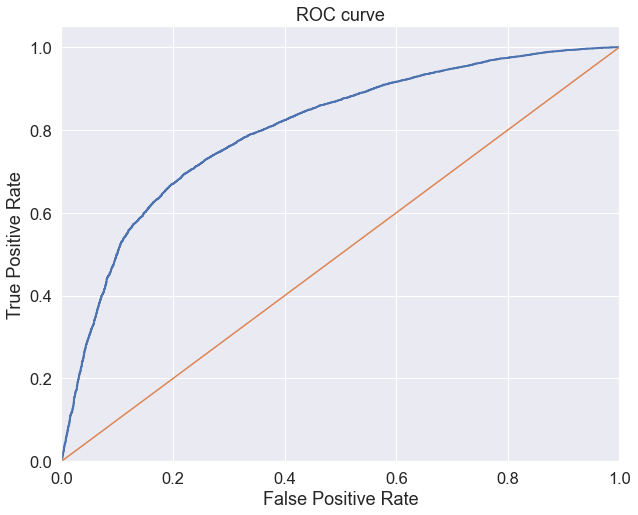

In [39]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Посомтрим на матрицу ошибок

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4804 4016]
 [1400 7280]]


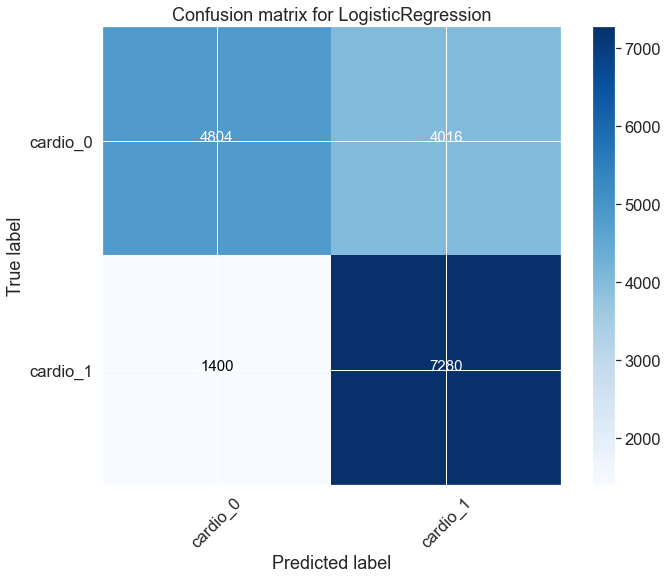

In [26]:
# Матрица для Логистической регрессии
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix for LogisticRegression')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[5138 3682]
 [1496 7184]]


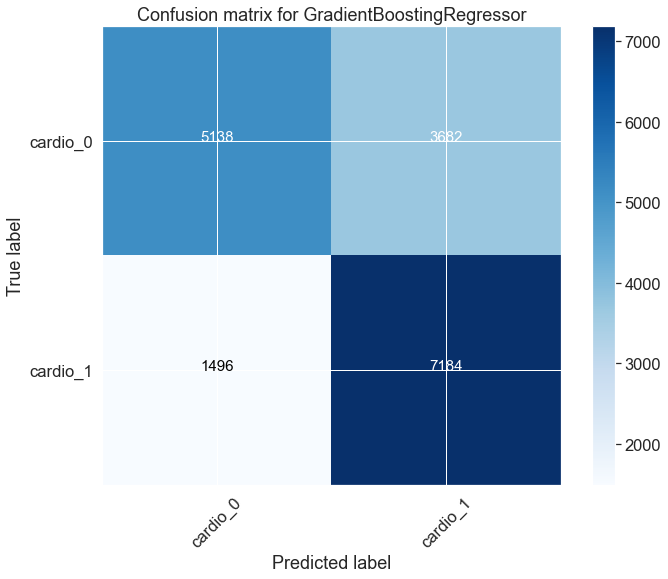

In [33]:
# Матрица для Градиентного бустинга
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix for GradientBoostingRegressor')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[5834 2986]
 [1827 6853]]


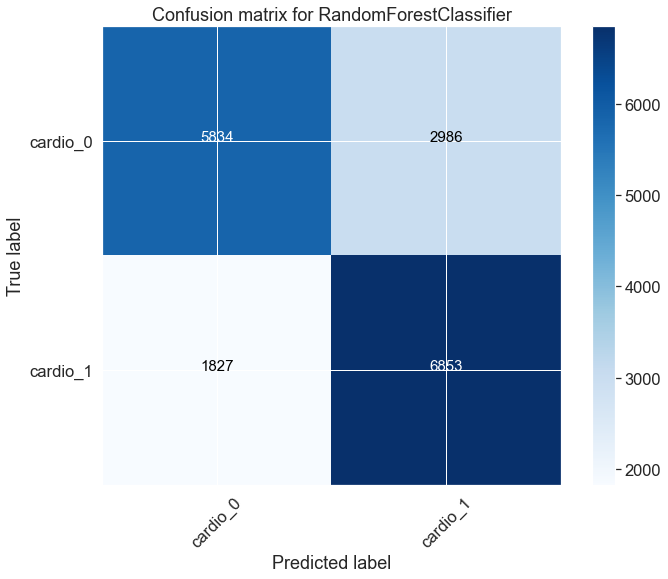

In [40]:
# Матрица для Случайного леса
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix for RandomForestClassifier')
plt.savefig("conf_matrix.png")
plt.show()

Матрицы ошибок:
1. Логистическая регрессия:
[[4804 4016]
 [1400 7280]]
2. Градиентный бустинг:
[[5138 3682]
 [1496 7184]]
3. Случайный лес:
[[5834 2986]
 [1827 6853]]

In [41]:
df_rez

,precision,recall,fscore,roc_auc,log_loss
LogisticRegression,0.645,0.839,0.729,0.782,0.579
GradientBoostingRegressor,0.661,0.828,0.735,0.796,0.547
RandomForestClassifier,0.697,0.790,0.740,0.802,0.542


### Выводы:
С т.зр. максимального попадания в заболевших клиентов TP и минимизации количества FN, лучше всего показала себя модель Логистической регрессии.
Модель Градиентного бустинга в целом неплохо классифицирует реально болеющих и не болеющих.
Модель Случайного леса больше пропускает реально заболевших клиентов.

Для дальнешнего анализа (какая модель эффективнее с т.зр. бизнеса) нужно накладывать финансовую составляющую вопроса.